# Сегментация клиентов банка 

## Презентация результатов
[Презентация](https://drive.google.com/file/d/16X6fav6qLsKjYWLIv_5bW3YnKfwDAz7V/view?usp=drive_link)

***Описание и цели проекта***

Для целей формирования маркетинговых предложений, направленных на предотвращение оттока и удержание действующих клиентов банка, требуется выделить сегменты клиентов, склонных к уходу из банка и дать рекомендации по их удержанию с учетом специфики сегмента на основании следующих имеющиеся в распоряжении данных о клиентах региональных офисов:

- идентификатор пользователя
- баллы кредитного скоринга
- город
- пол
- возраст
- количество баллов собственности
- баланс на счёте
- количество продуктов, которыми пользуется клиент
- есть ли кредитная карта
- активный клиент
- оценочный доход клиента
- признак оттока

На основаниии указанных данных:
- Выполним предобработку данных для анализа: выявим и при необходимости обработаем пропуски, дубликаты и аномалии
- Проведем исследовательский анализ данных: 
    - изучим портрет среднего клиента с признаками оттока и без
    - рассмотрим корреляцию признаков клиентов, имеющихся в распоряжении
    - изучим характер использования продуктов клиентами
- Сформулируем и проверим статистические гипотезы по отдельным признакам
- Выделим сегменты клиентов, склонных к оттоку и оченим их качество: охват общего числа клиентов, склонных к оттоку и сравним долю оттока с общей долей по банку
- Сформулируем общие выводы и рекомендации для каждого сегмента с учетом его специфики

## Предобработка данных

In [1]:
!python -m pip install phik

   ---------------------------------------- 0.0/666.3 kB ? eta -:--:--
   - ------------------------------------- 20.5/666.3 kB 330.3 kB/s eta 0:00:02
   -- ------------------------------------ 41.0/666.3 kB 487.6 kB/s eta 0:00:02
   ------------ --------------------------- 215.0/666.3 kB 1.6 MB/s eta 0:00:01
   --------------------------------- ------ 553.0/666.3 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 666.3/666.3 kB 3.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import math as mth
from scipy import stats as st
import plotly.express as px
import folium 
import json
import requests
from folium import Map, Choropleth, Marker
from folium.plugins import MarkerCluster
from plotly import graph_objects as go 
import phik

In [3]:
# Загрузим данные и выведем основную информацию о датасете
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [4]:
# Приведем названия всех столбцов к единому стилю
data = data.rename(columns = {'USERID': 'user_id', 'EST_SALARY': 'est_salary'})
data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

In [5]:
# Посчитаем процент пропущенных значений в каждом из столбцов
(data.isna().sum()/data.shape[0]*100).round(2)

user_id           0.00
score             0.00
city              0.00
gender            0.00
age               0.26
equity            0.00
balance          22.95
products          0.00
credit_card       0.00
last_activity     0.00
est_salary        0.00
churn             0.00
dtype: float64

**Почти у 23 % клиентов отсутствуют данные о балансе и у 0,26 % - о возрасте. Поскольку все клиенты в датасете - дейстувующие, а в соответствии со 115-ФЗ при принятии клиента на обслуживание выполняется обязательная его идентификация, т.е. предъявляется паспорт, который содержит дату рождения, пропуск, вероятно, имеет технические причины не будем его удалять, т.к. несмотря на пропуск в возрасте, это действующие клиенты, которые приносят доход банку и с ними также необходимо проводить работу по противодействию оттоку. Чтобы определить тактику обработки пропусков с столбце с балансом, исследуем его подробнее.**

In [6]:
# Определим, какое количество продуктов имеют клиенты, у которых пропуск в балансе и сколько из них - кредитные карты
data.query('balance != balance').groupby('products').agg({'credit_card': ['count', 'sum', 'mean']}).rename(columns = {'count': 'Всего c пропуском в балансе', 'sum':'Имеют кредитную карту', 'mean': 'Доля владельцев кредитных карт'})

credit_card                        \
         Всего c пропуском в балансе Имеют кредитную карту   
products                                                     
0                                  1                     0   
1                               1950                  1599   
2                                315                   257   
3                                 29                    16   

                                         
         Доля владельцев кредитных карт  
products                                 
0                              0.000000  
1                              0.820000  
2                              0.815873  
3                              0.551724

**Подавляющее большинство клиентов с пропусками имеют только один продукт. При этом среди владельцев 1 или 2-х продуктов около 82% имеют кредитную карту, а среди владельцев 3-х продуктов - 55 %. Таким образом большая часть пропусков может быть связана с отсутствием пассивных счетов у клиентов, которые пользуются лишь одним продуктом - кредитной картой.**

**Чтобы сделать предположения о природе пропусков, закодируем их и исследуем корреляцию пропущенных значений с другими полями**

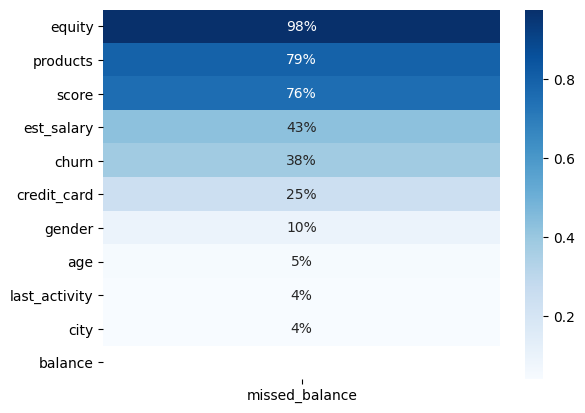

In [9]:
data_balance_analysis = data
data_balance_analysis['missed_balance'] = np.where(data_balance_analysis['balance']!= data_balance_analysis['balance'], 1, 0)
data_balance_analysiss_for_matrix = data_balance_analysis[['score', 'age', 'city', 'gender', 'equity', 'balance','products', 'credit_card', 'last_activity', 'est_salary', 'churn', 'missed_balance']]
sns.heatmap(data_balance_analysiss_for_matrix.phik_matrix(interval_cols = ['score', 'age',  'balance', 'est_salary']).loc[:, ['missed_balance']].drop('missed_balance').sort_values(by = 'missed_balance', ascending = False), fmt = ".0%", annot = True,  cmap = 'Blues')
plt.show()

**Наиболее сильная связь у пропущенных значений с оценкой собственности, количеством продуктов и баллами скоринга. Визуализируем распределение баллов скоринга в разбивке по наличию пропусков, в также доли пропусков в балансе у клиентов а разбивке по количеству продуктов, оценке собственности и оттоку.**

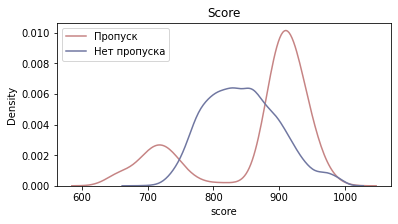

In [8]:
# Визуализируем распределение баллов скоринга в разбивке по пропускам в балансе

plt.figure(figsize = (6, 3))
sns.kdeplot(data = data_balance_analisys, x = 'score', hue = 'missed_balance', common_norm = False, palette = ['#7077A1', '#C68484'])
plt.title('Score')
plt.legend(['Пропуск', 'Нет пропуска'])
plt.show()

**У клиентов с пропусками в балансе есть два пиковых значения в распределении баллов скоринга, т.е. среди всех клиентов с пропусками можно выделить две часто встречающиеся группы клиентов с относительно низкими (более 700) и относительно высокими (более 900) баллами скоринга, клиенты без пропусков чаще имеют значения между этими пиками (более 800). Таким образом, вероятно, здесь имеет влияние третий фактор или сочетание нескольких, на оценке которых базируется методика скоринга.**

In [10]:
# Визуализиреум доли пропущенных значений по категориям для признаков с наиболее сильной корреляцией с пропусками
def cat_var_for_missed_balance(col):
    data_for_bar = data_balance_analysis.pivot_table(index = col, values= 'missed_balance', aggfunc = 'mean').reset_index()
    data_for_bar['missed_balance'] = data_for_bar['missed_balance'].round(2)
    ax = sns.barplot(x = data_for_bar[col], y = data_for_bar['missed_balance'], data = data_for_bar, color = '#C4D7E0', edgecolor = '#6C7A89')
    plt.axhline(y = data_balance_analisys['missed_balance'].mean(), color = 'grey', linestyle = '--')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2, p.get_height()), ha = 'center', va = 'bottom')
    return ax

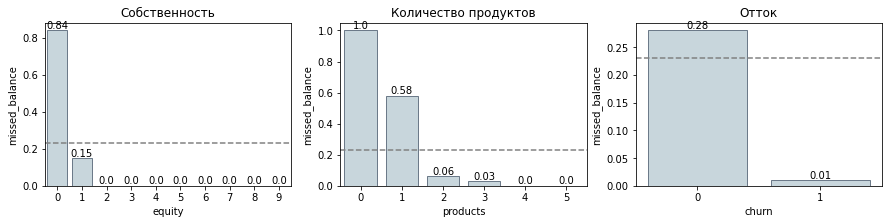

In [10]:
plt.figure(figsize = (15,3))
plt.subplots_adjust(hspace = 0.5)

plt.subplot(1, 3, 1)
cat_var_for_missed_balance('equity')
plt.title('Собственность')

plt.subplot(1, 3, 2)
cat_var_for_missed_balance('products')
plt.title('Количество продуктов')

plt.subplot(1, 3, 3)
cat_var_for_missed_balance('churn')
plt.title('Отток')


plt.show()

**Доля пропусков наиболее высока у клиентов, у которых отсутствует оценка собственности или она минимальна, также доля высока у владельцев одного продукта (а также у клиента, у которого нет продуктов, подробнее рассмотрим этого клиента далее), кроме того среди уходящих клиентов доля пропусков очень мала.**

**Таким образом, чаще всего пропуски присущи клиентам с одним продуктом, для более 80 % - это кредитная карта, чаще всего собственность у таких клиентов не указана или имеет минимальную оценку, а также такие клиенты редко уходят из банка.**

**Не будем удалять или заменять пропуски в балансе, чтобы не искажать описательные характеристики.**

In [11]:
# Проверим наличие полных явных дубликатов среди клиентов
print(f'Количество полных дубликатов клиентов: {data.duplicated().sum()}')

# А также дубликатов по уникальному идентификатору клиента

print(f'Количество дубликатов по идентификатору клиента: {data["user_id"].duplicated().sum()}')

Количество полных дубликатов клиентов: 0
Количество дубликатов по идентификатору клиента: 73


In [12]:
# Выведем несколько дубликатов по индентификатору
data[data['user_id'].duplicated(keep = False)].sort_values(by = 'user_id').head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,0
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,1
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,1
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,0
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0,1
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1,0
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1,0
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0,1
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1,0
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0,0


**Первые несколько дубликатов представляют собой разных клиентов в разных городах, у которых совпадают индентификаторы (о чем говорит разница в данных возраста, а в отдельных случаях - разный пол). Проверим, так ли это, выведем дубликаты по двум полям - идентификатор клиента и город.**

In [13]:
# Выведем дубликаты по двум полям
data[data[['user_id', 'city']].duplicated()]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance


**Наши предположения подтвердились - все дубликаты идентификаторов принадлежат клиентам из разных городов, т.е. по сути дубликатами не являются, удалять их нельзя. Такая ситуация может возникнуть в случае отсутствия сквозной нумерации заемщиков по всему банку, когда каждый филиал присваивает номер независимо.**

In [14]:
# Закодируем категориальные переменные - город и пол для целей корреляционного анализа
# Но сохраним оригинальные столбцы(создадим копии) для удобства дальнейшей визуализации
data[['city_copy', 'gender_copy']] = data[['city', 'gender']]
data = pd.get_dummies(data, columns = ['city_copy', 'gender_copy'], dtype = int).drop('gender_copy_Ж', axis = 1)

# Для удобства визуализаций также создадим столбцы с наименованием признака наличия кредитной карты и активности 
data['credit_card_description'] = data['credit_card'].replace(0, 'Нет карты').replace(1, 'Есть карта')
data['activity_description'] = data['last_activity'].replace(0, 'Не активен').replace(1, 'Активен')
data.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,city_copy_Ростов,city_copy_Рыбинск,city_copy_Ярославль,gender_copy_М,credit_card_description,activity_description
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0,1,0,0,Нет карты,Активен
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0,1,0,0,Есть карта,Не активен
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0,1,0,0,Есть карта,Активен
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,0,1,0,Нет карты,Активен
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,0,1,1,Есть карта,Не активен
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0,0,0,1,0,1,Есть карта,Не активен
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0,0,0,0,1,0,Нет карты,Активен
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0,0,0,0,1,0,Есть карта,Активен
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0,0,0,0,1,1,Есть карта,Не активен
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,1,0,0,1,0,Нет карты,Активен


In [15]:
# Для целей анализа создадим списки числовых и категориальных переменных:

cont_var = ['score', 'age'] # числовые непрерывные переменные (без предполагаемых значительных выбросов ввиду специфики признака)

dis_var = ['equity', 'products'] # числовые дискретные переменные

out_var = ['balance', 'est_salary'] # числовые непрерывные переменные (с потенциальными значительеыми выбросами)

cat_var = ['city', 'gender', 'credit_card', 'last_activity'] # категориальные переменные

In [16]:
# Проверим, как распределены числовые непрерывные переменные, чтобы предположить наличие/отсутствие аномалий
data[cont_var + out_var].describe()

,score,age,balance,est_salary
count,10000.000000,9974.000000,7.705000e+03,1.000000e+04
mean,848.699400,42.734409,8.277943e+05,1.478669e+05
std,65.448519,12.179971,1.980614e+06,1.393885e+05
min,642.000000,18.000000,0.000000e+00,2.546300e+03
25%,802.000000,33.000000,2.955542e+05,7.525190e+04
50%,853.000000,40.000000,5.242722e+05,1.196581e+05
75%,900.000000,51.000000,9.807058e+05,1.745005e+05
max,1000.000000,86.000000,1.191136e+08,1.395064e+06


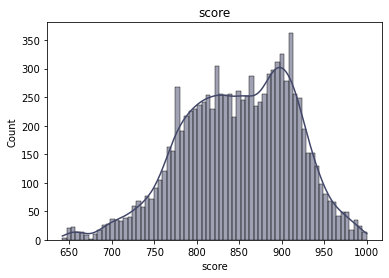

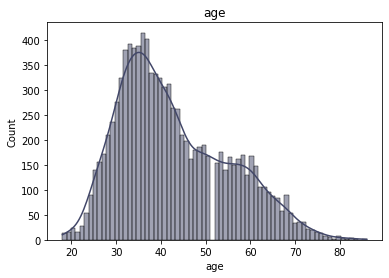

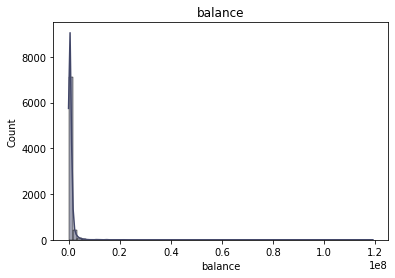

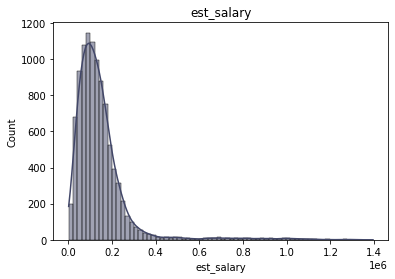

In [17]:
# Оценим распределение непрерывных переменных
for col in (cont_var + out_var): 
    sns.histplot(data[col], kde = True, bins = 70, color = '#424769')
    plt.title(col)
    plt.show()

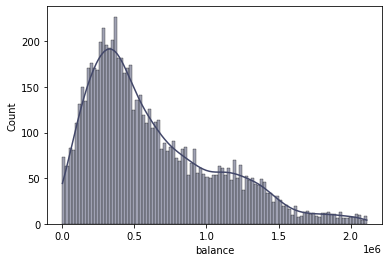

In [18]:
# Отдельно визуализируем данные о балансе, ограничив визуализацию 95 % данных, 
# чтобы рассмотреть основную часть распределения без выбросов

sns.histplot(data.loc[data['balance'] < np.percentile(data.dropna()['balance'], 95)]['balance'], kde = True, bins = 100, color = '#424769')
plt.show()

**Анализ данныз кредитного скоринга и возраста не выявил аномалий: разброс возраста от 18 (совершеннолетние граждане) до 86 лет (пенсионеры), при этом 75 % клиентов не старше 51 года, а баллы скоринга от 642 до 1000 (можно предположить шкалу до 1000 баллов), при этом 75 % клиентов имеют балл не превышающий 900. При этом, возраст имеет один явный пик, другой более сглаженный, что может говорить о наличии двух центров распределения - возрастных промежутков с большим количеством клиентов - около 35 и 55 лет. Подробнее рассмотрим на графиках плотности вероятности распределения на последующих шагах.**

**В данных баланса и заработной платы заметны значительные выбросы, о чем говорят длинные хвосты гистограмм, а также основные статистические показатели, полученные методом describe(): баланс от 0 до 119 млн руб, при 75 % не превышеющих 980 тыс. руб., а также оценочная заработная плата от 2,5 тыс. до почти 1,4 млн. руб. При значительном разбросе данные сложно назвать аномальными - баланс на счете - это его состояние на конкретную дату, т.е. он может быть высоким сегодня и нулевым завтра, например, если средства переводятся в счет аванса по договору ипотеки, кроме того, в исследовании необходимо учитывать различные сегменты клиентов, среди которых могут быть как среднестатические, так и клиенты с очень высоким доходом и остатками, поэтому выбросы удалять не будем. Аналогично оставим всех клиентов с высокой и маленькой оценочной заработной платой, т.к., во-первых, данные из внешних источников и мы не можем ручаться за их точность, во-вторых, нам в любом случае необходимо учитывать разные сегменты клиентов - с очень высокой и очень низкой заработной платой.**

In [19]:
# Оценим встречаемость дискретных переменных

for col in (dis_var + cat_var): 
    d = data[col].value_counts()
    d = pd.DataFrame(d)
    d['rate'] = (data[col].value_counts(normalize = True)*100).round(2)
    display(d)

,equity,rate
0,2592,25.92
5,1918,19.18
4,1850,18.50
3,1543,15.43
2,1052,10.52
1,774,7.74
6,161,1.61
7,80,0.80
8,17,0.17
9,13,0.13


,products,rate
2,5126,51.26
1,3341,33.41
3,1039,10.39
4,474,4.74
5,19,0.19
0,1,0.01


,city,rate
Ярославль,5888,58.88
Рыбинск,2695,26.95
Ростов,1417,14.17


,gender,rate
М,5005,50.05
Ж,4995,49.95


,credit_card,rate
1,6804,68.04
0,3196,31.96


,last_activity,rate
1,5235,52.35
0,4765,47.65


- **Больше четверти клиентов не указали в анкете собственность или ее не имеют.**
- **Более половины всех клиентов имеют два продукта, более 30 % - один продукт.**
- **Почти 60 % клиентов - из Ярославля, меньше всего - в Ростове (14 %).** 
- **Количество мужчин и женщин примерно равно.** 
- **Почти 70 % имеют кредитную карту.** 
- **Количество активных и неактивных клиентов близко к равенству - 52, 3 и 47,7 % соответственно.** 
- **Есть один заемщик, который не имеет продуктов, создавая тем самым дополнительную продуктовую категорию, рассмотрим этого заемщика.**

In [20]:
# Выведем информацию о заемщике, который имеет 0 продуктов
data.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,missed_balance,city_copy_Ростов,city_copy_Рыбинск,city_copy_Ярославль,gender_copy_М,credit_card_description,activity_description
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1,1,0,1,0,0,Нет карты,Не активен


**Вероятно, это клиент, который уже ушел (нет продуктов, нет активности, проставлен признак оттока). Удалим его, т.к. один ушедший клиент создает одну лишнюю категорию.**

In [21]:
# Удаляем клиента без действуюших продуктов

data = data.query('products != 0')

## Исследовательский анализ данных

### Отток в разрезе городов 

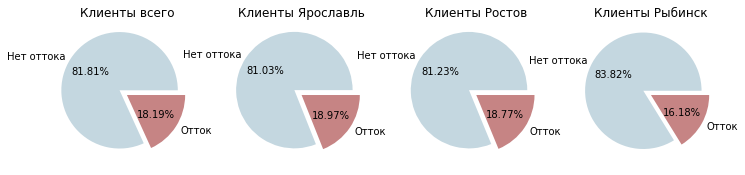

In [22]:
# Визуализируем долю клиентов с признаком оттока и без в целом по Банку, а также в разбивке по городам присутствия
def pie_plot_builder(table):
    churn_pie = table.groupby('churn')['user_id'].count().reset_index()
    (plt.pie(churn_pie['user_id'], 
             labels = churn_pie['churn'].replace(0, 'Нет оттока').replace(1, 'Отток'), 
             colors = ['#C4D7E0', '#C68484'], 
             autopct = '%.2f%%', explode = [0.15, 0])
    )

plt.figure(figsize = (12,12))

plt.subplot(1, 4, 1)
pie_plot_builder(data)
plt.title('Клиенты всего')

plt.subplot(1, 4, 2)
pie_plot_builder(data.query('city == "Ярославль"'))
plt.title('Клиенты Ярославль')

plt.subplot(1, 4, 3)
pie_plot_builder(data.query('city == "Ростов"'))
plt.title('Клиенты Ростов')

plt.subplot(1, 4, 4)
pie_plot_builder(data.query('city == "Рыбинск"'))
plt.title('Клиенты Рыбинск')

plt.show()

**Доли клиентов с признаком оттока сопоставимы и находятся в промежутке от 16 до 19 % в разных городах и в Банке в целом**

**Чтобы получить портрет Клиента посчитаем средние показатели для всех признаков клиентов банка в целом, а также в разбивке признака оттока, при этом для вычисления средних значений будем использовать:**

**- для числовых непрерывных переменных без значительных выбросов (баллы скоринга, возраст) - среднее**

**- для числовых числовых непрерывных переменных с выбросами и дискретных переменных (баллы собственности, баланс, количество продуктов, оценочная заработная плата) - медиану**

**- для бинарных категоричальных переменных (город, пол, наличие кредитной карты, активность) - моду**

### Портреты клиентов: уходящий, остающийся, средний по банку

In [23]:
# Создадим функцию, которая будет создавать сводные таблицы, применяя заданные функции к заданным столбцам
def get_av_pivot(col_list, aggfunction):
    return(data.pivot_table(index = 'churn', values = col_list, aggfunc = aggfunction))

# Объединим таблицы в одну по признаку оттока
average_data = get_av_pivot(cont_var, 'mean').join([get_av_pivot((dis_var + out_var), 'median'), get_av_pivot(cat_var, lambda x: x.mode())]) 

# Создадим список, содержащий новую строку - средние значения, рассчитанные по всему датафрейму
new_list = []
for column in average_data.columns.tolist():
    if column in cont_var:
        new_list.append(data[column].mean())
    if column in dis_var or column in out_var:
        new_list.append(data[column].median())
    if column in cat_var:
         new_list.append(data[column].mode()[0])

# Добавим список новой строкой
average_data.loc[len(average_data)] = new_list

pd.set_option('display.float_format', '{:.2f}'.format)
average_data = (average_data
                .T
                .rename(columns = {0: 'Клиент не уходит', 1: 'Клиент уходит', 2: 'Средний клиент Банка'}, index = {'age': 'Возраст', 'score': 'Балл скоринга', 'balance': 'Баланс', 'equity':  'Оценка собственности', 'est_salary': 'Оценочная з/п (доход)', 'products': 'Количество продуктов', 'city': 'Город', 'credit_card': 'Наличие кредитной карты', 'gender': 'Пол', 'last_activity': 'Активность'})
                .reset_index()
                .rename(columns ={'index': 'Признак'})
               )
average_data.replace(1, 'Да').replace(0, 'Нет')


churn,Признак,Клиент не уходит,Клиент уходит,Средний клиент Банка
0,Возраст,43.02,41.43,42.73
1,Балл скоринга,845.43,863.35,848.69
2,Баланс,475382.45,782410.47,524272.20
3,Оценка собственности,3.00,4.00,3.00
4,Оценочная з/п (доход),118257.71,125395.22,119661.51
5,Количество продуктов,2.00,2.00,2.00
6,Город,Ярославль,Ярославль,Ярославль
7,Наличие кредитной карты,Да,Да,Да
8,Пол,Ж,М,М
9,Активность,Нет,Да,Да


**Средний уходящий клиент банка чуть моложе среднего клиента банка, имеет более высокий балл скоринга, оценку собственнности, а его остаток на балансе почти в 2 раза выше, чаще всего - это мужчины.** 

**Лояльные клиенты, как правило, старше среднего клиента, имеют меньший балл скоринга, меньший остаток на балансе и оценочную заработную плату.**

### Непрерывные признаки: распределение в разрезе оттока

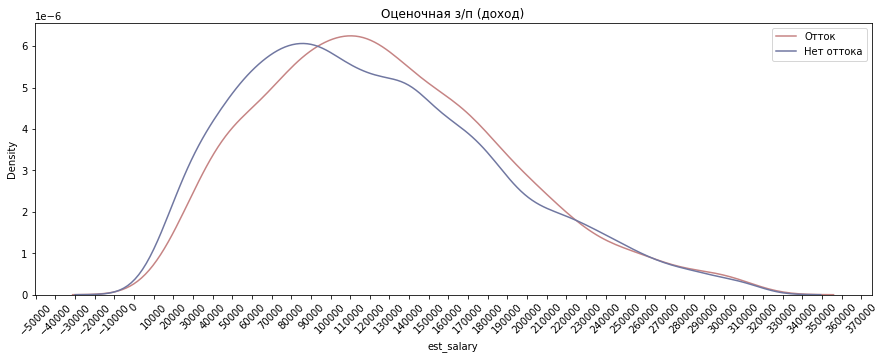

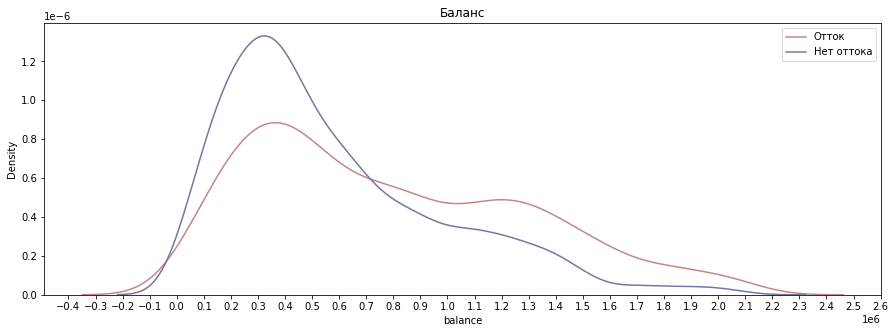

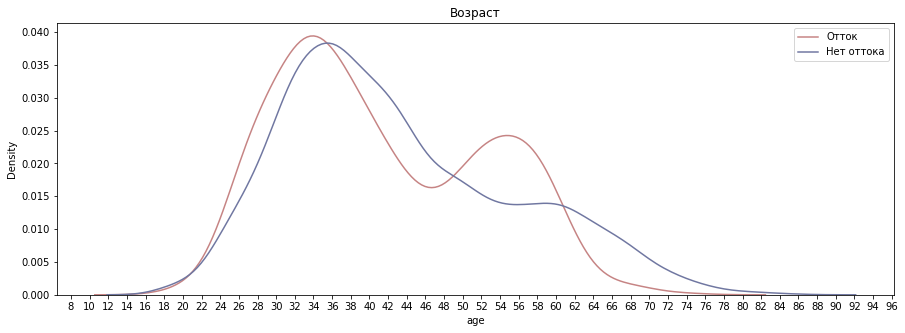

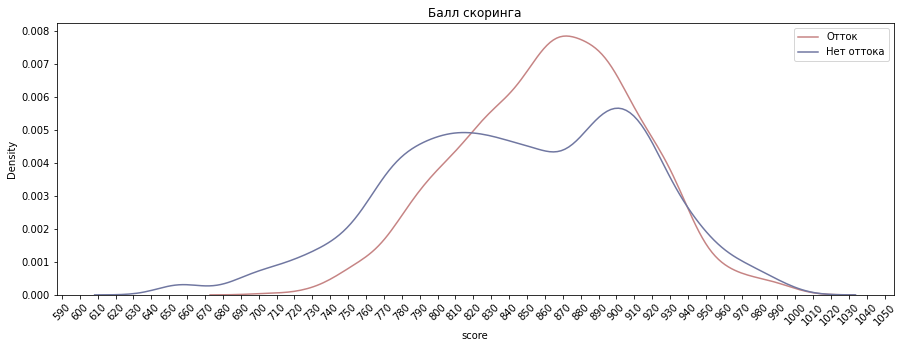

In [24]:
# Создадим функцию для визуализации распределения непрерывных переменных в разрезе признаков оттока, чтобы определить промежутки
# на которых вероятность, что клиент уходящий - выше

def cont_var_visual(dataset, col):
    plt.figure(figsize = (15,5)) 
    sns.kdeplot(data = dataset, x = col, hue = 'churn', common_norm = False, palette = ['#7077A1', '#C68484'])
    plt.legend(['Отток', 'Нет оттока'])

cont_var_visual(data.loc[data['est_salary'] < np.percentile(data['est_salary'], 95)], 'est_salary') # ограничим визуализацию 95% данных
plt.title('Оценочная з/п (доход)')
plt.locator_params(axis = 'x', nbins = 50)
plt.xticks(rotation = 45)

cont_var_visual(data.loc[data['balance'] < np.percentile(data.dropna()['balance'], 95)],'balance') # ограничим визуализацию 95% данных
plt.title('Баланс')
plt.locator_params(axis = 'x', nbins = 50)

cont_var_visual(data, 'age')
plt.title('Возраст')
plt.locator_params(axis = 'x', nbins = 50)

cont_var_visual(data, 'score')
plt.title('Балл скоринга')
plt.locator_params(axis = 'x', nbins = 50)
plt.xticks(rotation = 45)

plt.show()


**1. Оценочная з/п плата (доход).** 

Согласно графику плотности вероятности распределения дохода, клиенты с признаками оттока чаще имеют доход больше, чем клиенты без признаков оттока, о чем говорит смещенный вправо в сторону увеличения суммы дохода пик графика плотности распределения дохода клиентов с признаком оттока в сравнее с клиентами без него. Наибольшее число клиентов с оттоком - на промежутке примерно от 100 тыс. до 210 тыс. руб., при дальнейшем увеличении дохода разрыв сокращается, как и количество клиентов.

**2. Баланс.** 

Распределение остатков на балансе (пассивы) клиентов имеет большой разброс значений в сторону увеличения остатка баланса ("хвост" справа). При этом именно на этот "хвост" приходятся суммы остатков, которые чаще имеют клиенты с признаком оттока, т.е. клиенты с признаком оттока чаще имеют более высокие остатки на дебетовых и депозитных счетах в размере примерно от 700 тыс. руб.

**3. Возраст.**

Графики плотности распределения значений возраста имеют два пика (в районе 30 и в районе 50 лет), более ярко выраженные у клиентов с признаком оттока. При этом пики у клиентов с оттоком смещены влево, т.е. уходящие клиенты чаще моложе остающихся. В целом, чаще уходят клиенты в возрасте примерно от 22 до 34 и от 49 до 60.

**4. Баллы скоринга.**

Чаще уходят клиенты, которые имеют баллы в промежутке от 820 до 910 (на пике распределения), что по шкале до 1000 - достаточно высокое значение и несмотря на то, что нам неизвестны критерии оценки, может говорить о довольно высоком качестве уходящих клиентов.

### Категориальные и дискретные признаки: сравнение долей оттока по категориям

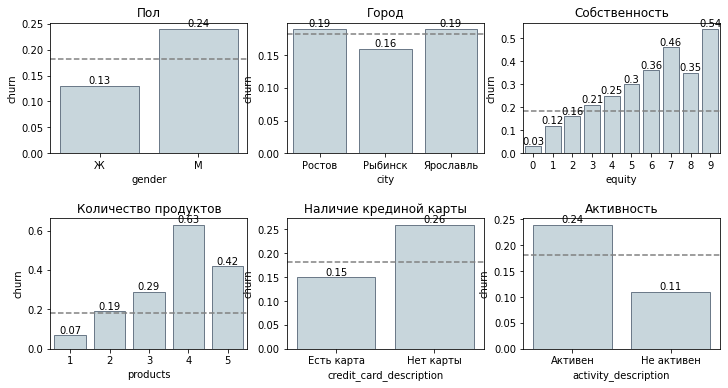

In [25]:
# Создадим функцию для визуализации распределения категориальных переменных

def cat_var_visual(col):
    data_for_bar = data.pivot_table(index = col, values= 'churn', aggfunc = 'mean').reset_index()
    data_for_bar['churn'] = data_for_bar['churn'].round(2)
    ax = sns.barplot(x = data_for_bar[col], y = data_for_bar['churn'], data = data_for_bar, color = '#C4D7E0', edgecolor = '#6C7A89')
    plt.axhline(y = data['churn'].mean(), color = 'grey', linestyle = '--')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2, p.get_height()), ha = 'center', va = 'bottom')
    return ax

plt.figure(figsize = (12,6))
plt.subplots_adjust(hspace = 0.5)

plt.subplot(2, 3, 1)
cat_var_visual('gender')
plt.title('Пол')

plt.subplot(2, 3, 2)
cat_var_visual('city')
plt.title('Город')

plt.subplot(2, 3, 3)
cat_var_visual('equity')
plt.title('Собственность')

plt.subplot(2, 3, 4)
cat_var_visual('products')
plt.title('Количество продуктов')

plt.subplot(2, 3, 5)
cat_var_visual('credit_card_description')
plt.title('Наличие крединой карты')

plt.subplot(2, 3, 6)
cat_var_visual('activity_description')
plt.title('Активность')

plt.show()

- Доля оттока среди клиентов - **мужчин** выше среднебанковской и составляет около 24 %. 
- Более лояльны клиенты Рыбинска, а доля оттока клиентов других городов совсем немного превышает среднюю долю по банку. 
- **Доля оттока растет вместе с баллами собственности** (за исключением 8 баллов) и превышает общебанковскую начиная с 3 баллов. Однако следует учитывать, что количество клиентов в группах с 7, 8 и 9 баллами не превышает 1 % от общего числа каждая.
- Среди клиентов, имеющих **от трех продуктов и более** доля оттока выше, чем средняя по банку.
- Доля оттока среди клиентов, **не имеющих кредитные карты выше** среднего по банку и составляет 26%
- Среди клиентов с признаком активности доля оттока выше общебанковской и составляет 24 %.

### Матрица корреляции

**Чтобы оценить связь между признаками, построим phik матрицу, которя в отличие от матрицы корреляции выявляет также нелинейную связь.**

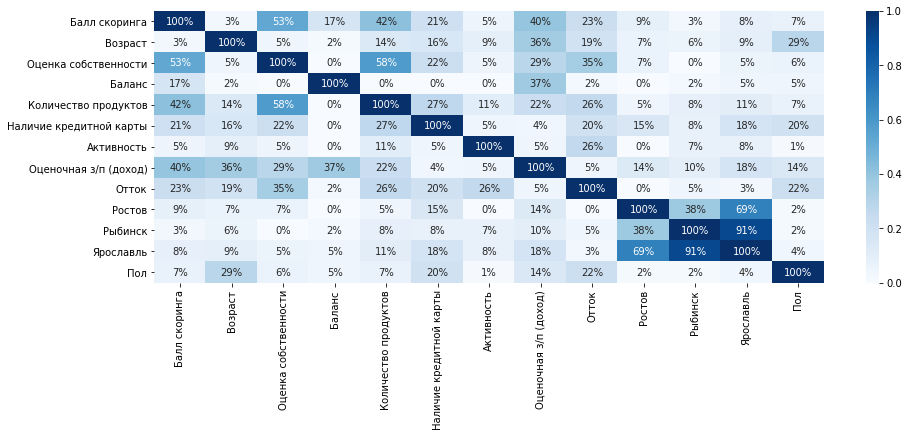

In [26]:
# Строим phik матрицу

data_for_matrix = data[['score', 'age', 'equity', 'balance','products', 'credit_card', 'last_activity', 'est_salary', 'churn','city_copy_Ростов', 'city_copy_Рыбинск', 'city_copy_Ярославль', 'gender_copy_М']]
data_for_matrix = data_for_matrix.rename(columns = {'churn':'Отток', 'age': 'Возраст', 'score': 'Балл скоринга', 'balance': 'Баланс', 'equity':  'Оценка собственности', 'est_salary': 'Оценочная з/п (доход)', 'products': 'Количество продуктов', 'credit_card': 'Наличие кредитной карты', 'last_activity': 'Активность', 'city_copy_Рыбинск': 'Рыбинск', 'city_copy_Ярославль': 'Ярославль', 'city_copy_Ростов': 'Ростов', 'gender_copy_М': 'Пол'})
plt.figure(figsize = (15,5)) 
sns.heatmap(data_for_matrix.phik_matrix(interval_cols =['Балл скоринга', 'Возраст', 'Баланс', 'Оценочная з/п (доход)']), fmt = ".0%", annot = True, cmap = 'Blues')
plt.show()


**Наиболее сильная связь между признаками (отток рассмотрим отдельно):**
- **у баллов скоринга с:** оценкой собственности (53 %), количеством продуктов (42 %), оценочной заработной платой (40 %), наличием кредитной карты (21 %)
- **у возраста с:** оценочной заработной платой (36 %), полом (29 %)
- **оценкой собственности с:** баллами скоринга (53 %), количеством продуктов (58 %), наличием кредитной карты (22 %), оценочной заработной платой (29 %)
- **у баланса с:** оценочной заработной платой  (37 %)
- **у количества продуктов с:** баллами скоринга (42 %), оценкой собственности (58 %), наличием кредитной карты (27 %), оценочной заработной платой (22 %)
- **у кредитной карты с:** баллами скоринга (21 %), оценкой собственности (22 %), количеством продуктов (27 %), полом (20 %)
- **у оценочной заработной платы с:** баллами собственности (40 %),  балансом (37 %), возрастом (36 %), баллами собственности (29 %),  количеством продуктов (22 %)
- **у пола с:** возрастом (29 %), наличием кредитной карты (20 %)

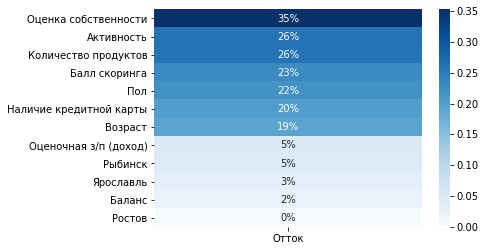

In [27]:
# Рассмотрим, как отток связан с другими признаками
sns.heatmap(data_for_matrix.phik_matrix(interval_cols =['Балл скоринга', 'Возраст', 'Баланс', 'Оценочная з/п (доход)']).loc[:, ['Отток']].drop('Отток').sort_values(by = 'Отток', ascending = False), fmt = ".0%", annot = True,  cmap = 'Blues')
plt.show()

**Наиболее сильная связь у оттока с баллами собственности, активностью, количеством продуктов, баллами скоринга, полом, наличием кредитной карты и возрастом.**

### Характер использования продуктов банка

**Чтобы составить представление о характере использования клиентами продуктов, исследуем доступные для этого признаки:**
- **количество продуктов** 
- **наличие кредитной карты** (нулевой баланс и один продукт - кредитная карта - нет пассивов)

Дополнительно рассмотрим баланс, заработок и баллы скоринга в качестве характеристик клиентов каждой группы.

In [28]:
# Рассмотрим характеристики клиентов в зависимости от характера использования продуктов

data.groupby('products')[['churn', 'credit_card', 'balance', 'est_salary', 'equity', 'score']].agg({'churn':['mean', 'count'], 'credit_card':['mean', 'count'], 'balance':['median', 'count'], 'est_salary':['median', 'count'], 'equity':['median', 'count'], 'score':['median', 'count']})


churn       credit_card         balance       est_salary        \
          mean count        mean count    median count     median count   
products                                                                  
1         0.07  3341        0.86  3341 415369.49  1391  142185.24  3341   
2         0.19  5126        0.63  5126 514916.20  4811  109493.96  5126   
3         0.29  1039        0.36  1039 666336.60  1010  105625.84  1039   
4         0.63   474        0.68   474 939342.90   474  122472.51   474   
5         0.42    19        1.00    19 282262.33    19  106033.79    19   

         equity        score        
         median count median count  
products                            
1             0  3341 884.00  3341  
2             3  5126 844.00  5126  
3             4  1039 828.00  1039  
4             4   474 874.00   474  
5             4    19 851.00    19

**Клиенты, у которых больше продуктов, имеют большие остатки на счетах (кроме владельцев 5-ти продуктов, что может объясняться небольшой выборкой), что может быть показателем большего количества сберегательных продуктов, таких как депозиты. Вместе с тем, они имеют большую оценку собственности и больший отток.**

## Проверка статистических гипотез

### Гипотеза о равенстве средних возрастов клиентов с 1 и 2-мя продуктами.

**С учетом выличины рассматриваемого датасета, согласно центральной предельной теореме, выборочное среднее распределено близко к нормальному вне зависимости от типа распределения генеральной совокупности при условии конечной дисперсии, поэтому для оценки статистической значимости разницы среднего возраста клиентов имеющих 1 и имеющих 2 продукта можно использовать t-тест для двух независимых выборок для проверки гипотезы о равенстве средних двух генеральных совокупностей.**

1. **Сформулируем нулевую гипотезу:** нет статистически значимой разницы между средним возрастом клиентов с 1-м и 2-мя продуктами.
2. **Сформулируем альтернативную гипотезу:** между средним возрастом пользователей с 1-м и 2-мя продуктами есть статистически значимая разница.


In [29]:
# зададим уровень статистической значимости
alpha = 0.01 # установим уровень статистической значимости 0.01, т.к. выборка большая

one_prod_clients_age = data.dropna(subset = ['age']).query('products == 1')['age']

two_prod_clients_age = data.dropna(subset = ['age']).query('products == 2')['age']

# проводим t-test для двух выборок
# используем параметр equal_var=False, т.к. размеры выборок разные

results = st.ttest_ind(one_prod_clients_age, two_prod_clients_age, equal_var=False)

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.03299080704232691
Нет оснований отвергнуть нулевую гипотезу


**С учетом выбранного уровня статистической значимости полученный p-value позволяет не отвергать гипотезу в пользу альтернативной - между средним возрастом клиентов с 1-м и 2-мя продуктами нет статистически значимой разницы.**

### Гипотеза о равенстве долей оттока мужчин и женщин

**Проверим гипотезу раазнице долей оттока среди мужчин и женщин, которых в банке примерно равное количество (4991 и 4983 соответственно). Для проверки равенства долей используется z-тест.**
1. **Сформулируем нулевую гипотезу:** между долей уходящих клиентов-мужчин и клиентов-женщин нет статистически значимой разницы.
2. **Сформулируем альтернативную гипотезу:** между долей уходящих клиентов-мужчин и клиентов-женщин есть статистически значимая разница.

In [30]:
# Проверим разницу долей с помощью z-теста

alpha = 0.01

successes = np.array([data.query('gender_copy_М == 1 and churn == 1')['user_id'].count(), data.query('gender_copy_М == 0 and churn == 1')['user_id'].count()])
trials = np.array([data.query('gender_copy_М == 1 and churn == 0')['user_id'].count(), data.query('gender_copy_М == 0 and churn == 0')['user_id'].count()])

# доля оттока среди мужчин:
p1 = successes[0]/trials[0]

# доля оттока среди женщин:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Полученное значение p-value позволяет отклонить нулевую гипотезу в пользу альтернативной - между долями есть статистически значимая разница**

## Промежуточные выводы

1. Анализ портрета среднего клиента (с признаком оттока, без него и среднего по банку) показал, что:
    - уходящий клиент, как правило, моложе, среднестатического клиента Банка, имеет большую оценочную заработную плату, большие остатки на пассивных счетах, баллы скоринга и имеет более высокую оценку собственности 
    - клиент, который остается, наоборот - старше, имеет балл скоринга, остатки на пассивных счетах и оченочную заработную плату ниже среднестатического клиента Банка.
    
    Таким образом, уходящие клиенты - клиенты довольно высокого качетва с точки зрения потенциального дохода банка, о чем говорят сравнительно высокие показатели дохода, остатков и скоринга, а также качества собственности.
    
2. Анализ распределения непрерывных признаков в разрезе признака оттока также подтвердили, что вероятность оттока на более высоких значения дохода и остатков выше.

3. Анлиз распределенияя категориальных и дискретных признаков также подтвердил, выводы, полученные в результате анализа портрета клиента: среди клиентов, с оценкой собственности от 3-х (по шкале до 9) доля оттока выше среднебанковской. Кроме того, доля оттока выше среднебанковской среди клиентов, имеющих от 3-х продуктов, а также среди тех, у кого нет кредитной карты, среди мужчин и среди активных пользователей.

4. Анализ связей между признаками показал, что на отток наиболее сильно влияет оценка собственности (35%), активность и количество продуктов (по 26 %), баллы скоринга (23 %), пол (22 %), наличие кредитной карты (20 %) и возраст (19 %). При этом, ряд признаков сильно коррелирует между собой - количество продуктов и оценка собственности (58 %), баллы скоринга и оценка собственности (53 %), баллы скоринга и количество продуктов (42 %), баллы скоринга и оценочная з/п (доход) (40 %).

5. Анализ статистических гипотез подтвердил наличие статистически значимой разницы в долях оттока мужчин и женщин, а установил, что статистической разницы в возрасте между клиентами с одним и двумя продуктами нет.

Таким образом, наиболее сильно оттоку подвержены клиенты:
- с большим количеством продуктов (возможно, в банке нет конкурентоспособных "коробочных" продуктов, когда их сочетание делает использование выгоднее, например, использование одного, дает скидку на другой, либо неконкурентоспособны условия по различным дополнительным продуктам отличным от кредитной и дебетовой карты - это требует дополнительного анализа таких продуктов)
- имеющие сравнительно большие остатки на счетах, доход и баллы скоринга (возможно, нет отдельно выделенного направления работы с вип-клиентыми или оно развито в недостаточной степени, а также отдельного исследования требуют продукты банка по управлению пассивами - депозити, инвестиционные и сберегательные счета)
- имеющие высокую оценку собственности (особое внимание стоит уделить страховым продуктам)
- не имеющие кредитную карту (наличие долговых обязательств, вероятно, сильнее удерживает клиента в банке, чем пассивные продукты, т.к. требуется больше усилий для смены банка)

## Сегментация

**С учетом проведенного анализа выведем несколько сегментов клиентов, подверженных оттоку, и дадим рекомендации по работе с каждым из них.** 

In [31]:
# Создадим функцию для формирования сегмента по заданным условиям и оценки его размера и качества
def get_segment(clause):
    segment = data.query(clause).agg({'churn': ['mean', 'sum', 'count']}).T.rename(columns = {'mean': 'Доля оттока', 'sum': 'Количество уходящих', 'count': 'Размер сегмента'})
    segment['Превышение среднего оттока'] = segment['Доля оттока']/data['churn'].mean()
    return segment

In [32]:
# Сегмент 1: активные молодые клиенты без кредитной карты

segment_1 = get_segment('credit_card == 0 and age < 35 and last_activity == 1')
segment_1 = segment_1.rename(index = {'churn':'Нет кредитной карты + Возраст до 35 + Активность'})
segment_1

,Доля оттока,Количество уходящих,Размер сегмента,Превышение среднего оттока
Нет кредитной карты + Возраст до 35 + Активность,0.50,230.00,463.00,2.73


In [33]:
#  Сегмент 2: мужчины с собственностью и высокой з/п

segment_2 = get_segment('gender_copy_М == 1 and equity >= 4 and est_salary >= 100000 and est_salary <= 220000')
segment_2 = segment_2.rename(index = {'churn':'Мужчины с оценкой собственности > 4 и доходом от 100 до 220 тыс.'})
segment_2

,Доля оттока,Количество уходящих,Размер сегмента,Превышение среднего оттока
Мужчины с оценкой собственности > 4 и доходом от 100 до 220 тыс.,0.41,399.00,970.00,2.26


In [34]:
#  Сегмент 3: Клиенты с высокими пассивами, баллами скоринга и имеющие несколько (от 3х продуктов)

segment_3 = get_segment('products >= 3 and balance >= 700000 and score > 820')
segment_3 = segment_3.rename(index = {'churn':'От трех продуктов, баланс от 700000, балл скоринга от 820'})
segment_3

,Доля оттока,Количество уходящих,Размер сегмента,Превышение среднего оттока
"От трех продуктов, баланс от 700000, балл скоринга от 820",0.59,342.00,584.00,3.22


**Объединим сегменты в одну таблицу**

In [35]:
pivot_segments = pd.concat([segment_1, segment_2, segment_3])
pivot_segments

,Доля оттока,Количество уходящих,Размер сегмента,Превышение среднего оттока
Нет кредитной карты + Возраст до 35 + Активность,0.50,230.00,463.00,2.73
Мужчины с оценкой собственности > 4 и доходом от 100 до 220 тыс.,0.41,399.00,970.00,2.26
"От трех продуктов, баланс от 700000, балл скоринга от 820",0.59,342.00,584.00,3.22


## Выводы и рекомендации

На основании данных о действующих клиентах банка был проведен анализ, который позволил выделить 4 сегмента клиентов, в которых доля оттока более чем в два раза превышает среднюю по банку. С учетом специфики сегментов, предложим ряд мер, направленных на удержание клиентов в банке.

**Сегмент 1. Активные молодые клиенты без кредитной карты.** 

**Критерии:** Нет кредитной карты, возраст до 35 лет, активные клиенты

**Размер сегмента**: 463 человека. 

**Доля оттока**: 50 %

**Меры**: Молодые клиенты, уже активно использующие продукты банка, но у которых до сих пор нет кредитной карты. Возможно, они являются зарплатными клиентами и, соответственно, даже имеют льготные условия, о которых им неизвестно, или пользуются кредитной картой другого банка. Рекомендацией может быть дополнительное информирование в виде предодобренных предложений по кредитным картам исходя из баллов скоринга при обращении в банк или действиях с действующими продуктами банка, а также использование в рекламе фокуса на молодой возраст и потребности, которые можно закрыть с помощью кредитной карты - петешествия, спорт, дополнительное образование.

**Сегмент 2. Мужчины с качественной собственностью и средним+ доходом** 

**Критерии:**  Мужчины, оценка собственности от 4,  доход от 100 до 220 тыс. руб. 

**Размер сегмента**: 970 человек. 

**Доля оттока**: 41 %

**Меры**: Мужчины, у которых есть ценная с точки зрения банка собственность и средний по банку или выше доход. Эффективным может быть предложение страховых продуктов для сохранения собственности, а также кредитные продукты, которые исходя из наличия ликвидного ценного залога могут быть предложены на более выгодных условиях, чем для среднестатического клиента банка - по более низкой ставке или в большем размере. Также возможен фокус на пол в рекламе, например, предложение потребительского кредита в соответствии с потребностями и особенностями целевого сегмента - на ремонт дома, автомобиля или покупку гаража, а также размещение рекламы в спортзалах, автосервисах, строительных магазинах и пр.

**Сегмент 3. Клиенты с несколькими (от 3-х) продуктами, высокими остатками на пассивных счетах и высокими баллами скоринга** 

**Критерии:** От трех продуктов, остатки на пассивных счетах от 700 000 руб., баллы скоринга от 820 (по шкале до 1000)

**Размер сегмента**: 584 человека. 

**Доля оттока**: 59 %

**Меры**: Качественные клиента банка (с высокими баллами скоринга, которые тесно связаны с баллом собственности и оценочной заработной платой) с отностительно высокими баллами скоринга и несколькими продуктами. Эффективным может быть разработка "коробочных" продуктов, когда совместное использование продуктов делает их более выгодным для клиента, а также дает возможность банку заработать на дополнительном к тому что уже имеет клиент наполнению коробки. Такие пакетные предложения есть у других банков и их отсутствие может привести к уходу клиента в другой банк. Также стоит обратить внимание на инструменты управления пассивами для клиентов с высокими доходами, например, инвестиционные и сберегательные счета. Более эффективным может быть работы с такими клиентами напрямую через персональных менеджеров, вместо использования рассылки и иных массовых методов.